In [1]:
import os
import matplotlib.pyplot as plt
from os import listdir
import random
import numpy as np
import cv2 as cv

In [2]:
#loading dataset 
dataset_location = 'C:/Users/sushl/Desktop/visual odometry/adc'
L = os.listdir(dataset_location)

In [3]:
#ground Truth
ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/poses.txt',delimiter = ' ')
ground_truth.shape
gx = ground_truth[:,3]
gz = ground_truth[:,11]

In [4]:
#calibration matrix
k =np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02], 
             [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02], 
             [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]])
sift = cv.SIFT_create()
bf = cv.BFMatcher()
brief = cv.xfeatures2d.BriefDescriptorExtractor_create()

3d to 2d

In [5]:
k = np.array([[518.56666108, 0., 329.45801792],
    [0., 518.80466479, 237.05589955],
    [  0., 0., 1.]])


In [6]:
#function for finding kps
def keypoints(img,no_features):
    pt = cv.goodFeaturesToTrack(img, mask = None, maxCorners = no_features, qualityLevel = 0.01, minDistance = 1, blockSize = 5, useHarrisDetector = True, k = 0.04  )
    return pt    

In [7]:
def optical_flow_matches(imgb,imga,kpa,window_size):
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (window_size,window_size),
                      maxLevel = 2,
                      criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    kpb, st, err = cv.calcOpticalFlowPyrLK(imga, imgb, kpa, None, **lk_params)
    ptsb = kpb[st == 1]
    ptsa = kpa[st == 1]
    return ptsa[:],ptsb[:],kpa[:],kpb[:]
    

In [8]:
def point3D(k,R,t,pts1,pts2):
    rt = np.zeros((3,4))
    rt[:3,:3] = np.identity(3)
    projMatr1 = k@rt
    rt2 = np.zeros((3,4))
    rt2[:3,:3] = R
    rt2[:,3] = t.reshape((3))
    projMatr2 = k@rt2
    points4D = cv.triangulatePoints(projMatr1,projMatr2,pts1 ,pts2)
    points3D = points4D / points4D[3,:]
    return points3D.T[:,:3]

In [9]:

#for first two images
img1 = cv.imread(dataset_location +'/'+ L[1],cv.IMREAD_GRAYSCALE)
img2 = cv.imread(dataset_location +'/'+ L[2],cv.IMREAD_GRAYSCALE)
ref1 = keypoints(img1,700)
ref2 = keypoints(img2,700)
E, mask = cv.findEssentialMat(ref1,ref2,k,cv.RANSAC, prob = 0.999,threshold = 0.4,mask=None)
#inlier points
pts1 = ref1[mask.ravel()==1]
pts2 = ref2[mask.ravel()==1]
#recovering pose info
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
pointcloud = point3D(k,R,t,pts1,pts2)
retval, rvec, tvec, inliers = cv.solvePnPRansac(pointcloud,pts2, k, (0.1,0.1,0.1,0.1),useExtrinsicGuess = False ,iterationsCount = 100,reprojectionError = 5.0,confidence = 0.80,)
r2 = cv.Rodrigues(rvec)
R = r2[0]
print(t)

[[-0.48959276]
 [-0.06695254]
 [ 0.86937695]]


In [10]:
translations = []
rotations = []
#for remaining images
frame = 2
matches = 100
translations.append(np.zeros(t.shape))
translations.append(t)
rotations.append(np.identity(3))
rotations.append(R)

#defining frames and keypoints of trigulating 3d points
framet1 = img1[:]
framet2 = img2[:]
rt12 = R
tt12 = t
ref = ref1
#previous 2 frames
framep1 = img1[:]
framep2 = img2[:]
Rp = R
Tp = t
t0 = translations[0]
r0 = rotations[0]
countif1 = 0
countexcept = 0
while(frame < len(L)-2):
    current_img = cv.imread(dataset_location +'/'+ L[frame],cv.IMREAD_GRAYSCALE)
    pt1,imgpoints,kpt1,kpi = optical_flow_matches(current_img,framet1,ref,15)
    t1,t2,kpt1,kpt2 = optical_flow_matches(framet2,framet1,pt1.reshape((-1,1,2)),15)
    m = min(len(t1),len(t2),len(imgpoints))
    imgpoints = imgpoints[:m,:]
    t1 = t1[:m,:]
    t2 = t2[:m,:]
    print(len(t1),len(t2),len(imgpoints))
    pointcloud = point3D(k,rt12,tt12,t1.reshape((-1,1,2)),t2.reshape((-1,1,2)))
    if matches > 24 and(countif1 < 10 and countexcept < 10):
        try:
            retval, rvec, tvec, inliers = cv.solvePnPRansac(pointcloud,imgpoints, k, (0.1,0.1,0.1,0.1))
            print(retval,tvec,len(inliers))
            if retval == True:
                translations.append(t0 + rotations[0]@tvec)
                Ri = cv.Rodrigues(r0@rvec)
                #print(Ri)
                Rt = Ri[0]
                rotations.append(Rt)
                #matches = len(inliers)
                print(matches)
                framep1 = framep2[:]
                framep2 = current_img[:]
                Rp = rotations[frame]@rotations[frame-1].T
                Tp = translations[frame] - translations[frame-1]
                countif1 = 0
                countexcept = 0
            else:
                framet1 = framep1[:]
                framet2 = framep2[:]
                rt12 = Rp
                tt12 = Tp
                ref = keypoints(framet1,700)
                t0 = translations[frame - 2]
                R0 = rotations[frame - 2]
                frame = frame - 1
                matches = 50
                countif1 = countif1 + 1
                print(1)

        except:
            framet1 = framep1[:]
            framet2 = framep2[:]
            rt12 = Rp
            tt12 = Tp
            ref = keypoints(framet1,700)
            t0 = translations[frame - 2]
            R0 = rotations[frame - 2]
            frame = frame - 1
            matches = 50
            countexcept = countexcept + 1
            print('except')
            
    print(frame)
    frame = frame + 1

697 697 697
True [[-0.57437959]
 [-0.12276791]
 [ 0.49385582]] 157
100
2
695 695 695
True [[-0.65069332]
 [-0.16527586]
 [ 0.37161705]] 131
100
3
694 694 694
True [[-0.65435878]
 [ 0.84064995]
 [ 0.27519904]] 123
100
4
692 692 692
True [[ 0.55215082]
 [-0.322278  ]
 [-0.28243616]] 121
100
5
692 692 692
True [[-0.63946057]
 [ 0.51535765]
 [-0.68158077]] 113
100
6
684 684 684
True [[-0.00751422]
 [-0.10780479]
 [ 0.08799503]] 115
100
7
678 678 678
True [[-0.55052486]
 [ 0.94718147]
 [ 0.10773036]] 72
100
8
678 678 678
True [[ 0.02048902]
 [-0.19757978]
 [ 0.19024008]] 100
100
9
677 677 677
True [[ 6.71320457e-05]
 [-3.42933657e-02]
 [ 8.07309755e-02]] 87
100
10
677 677 677
True [[-0.00254665]
 [-0.01664458]
 [ 0.01258885]] 70
100
11
674 674 674
True [[ 0.75638051]
 [-0.11276324]
 [-0.24629875]] 76
100
12
672 672 672
True [[-0.00735966]
 [-0.01585228]
 [ 0.04091151]] 68
100
13
669 669 669
True [[ 0.04909769]
 [ 0.107613  ]
 [-0.06571936]] 72
100
14
669 669 669
True [[ 0.11245114]
 [-1.078

True [[-0.50302593]
 [-0.07510655]
 [ 0.77939898]] 30
100
116
596 596 596
True [[0.03248545]
 [0.32551846]
 [0.21058754]] 33
100
117
596 596 596
True [[-0.01071665]
 [-0.00981496]
 [ 0.03218278]] 32
100
118
597 597 597
True [[-0.22492349]
 [-0.19994174]
 [ 0.56764687]] 33
100
119
598 598 598
True [[ 0.18730218]
 [ 0.0203191 ]
 [-0.2872764 ]] 38
100
120
598 598 598
True [[-0.12788583]
 [-0.02183281]
 [ 0.24937311]] 37
100
121
601 601 601
True [[ 0.50140819]
 [ 0.16158577]
 [-0.80595472]] 44
100
122
600 600 600
True [[-5.75521817]
 [-1.95407588]
 [20.83881538]] 31
100
123
600 600 600
True [[-0.54430539]
 [-0.11658616]
 [ 0.92709951]] 26
100
124
595 595 595
True [[-0.06911717]
 [-0.02941453]
 [ 0.1229003 ]] 43
100
125
596 596 596
True [[ 0.92552734]
 [ 0.40103961]
 [-1.99349721]] 45
100
126
596 596 596
True [[ 0.232677  ]
 [-0.05076264]
 [-0.09446257]] 45
100
127
596 596 596
True [[ 0.35075756]
 [-0.32076839]
 [-0.03424099]] 41
100
128
596 596 596
True [[ 0.20518568]
 [ 0.04325692]
 [-0.3

True [[ -7.97244072]
 [  4.99298755]
 [-43.70415798]] 22
100
227
635 635 635
True [[-0.63810638]
 [-0.27815267]
 [ 0.55007829]] 21
100
228
643 643 643
True [[ -1196600.53594108]
 [  1818722.46911479]
 [-41646906.29933546]] 24
100
229
638 638 638
True [[ 0.19425969]
 [-0.02884282]
 [-0.31022662]] 24
100
230
650 650 650
True [[ 0.6281284 ]
 [ 0.26261818]
 [-0.33701493]] 21
100
231
663 663 663
True [[ -218.77590397]
 [  101.20244674]
 [-1512.24151937]] 27
100
232
667 667 667
True [[ 0.15094221]
 [-0.56494933]
 [-0.64700355]] 6
100
233
668 668 668
True [[-0.17833073]
 [-0.27026546]
 [ 1.74703347]] 12
100
234
666 666 666
True [[-0.1827845 ]
 [ 0.83070245]
 [-0.99333474]] 13
100
235
666 666 666
True [[ 0.45070934]
 [-0.39060771]
 [ 0.06159853]] 9
100
236
662 662 662
True [[ 1.08169461]
 [ 0.19963061]
 [-1.99748877]] 11
100
237
660 660 660
True [[-0.77258313]
 [-0.15779177]
 [-1.69095271]] 15
100
238
656 656 656
True [[-0.00699997]
 [-0.08947794]
 [-0.32169193]] 14
100
239
653 653 653
True [[

100
339
656 656 656
True [[-0.53998331]
 [-0.43131451]
 [-0.09932792]] 49
100
340
656 656 656
True [[1.21477436]
 [0.06470652]
 [2.09096573]] 30
100
341
657 657 657
True [[-0.04628517]
 [ 0.17249488]
 [ 0.08101901]] 42
100
342
657 657 657
True [[ 0.20704233]
 [-1.82974272]
 [-1.26022597]] 33
100
343
656 656 656
True [[-0.45094292]
 [ 0.67863207]
 [-0.25735769]] 37
100
344
656 656 656
True [[ 0.20690561]
 [ 0.76172842]
 [-0.36026547]] 41
100
345
653 653 653
True [[-0.35432119]
 [ 0.83300306]
 [ 0.25025579]] 41
100
346
654 654 654
True [[0.22255256]
 [1.33930133]
 [0.65614038]] 34
100
347
652 652 652
True [[-0.70295851]
 [-2.73125621]
 [ 1.15772837]] 25
100
348
653 653 653
True [[ 0.09311092]
 [-0.06223611]
 [ 0.3581152 ]] 36
100
349
654 654 654
True [[-0.59467941]
 [-0.18756519]
 [-0.1098381 ]] 49
100
350
652 652 652
True [[-4.37624185]
 [ 2.9685311 ]
 [10.72745026]] 39
100
351
652 652 652
True [[ 2.27264957]
 [ 0.14129654]
 [-1.67027858]] 37
100
352
654 654 654
True [[-0.04579703]
 [ 0

100
456
630 630 630
True [[ 0.04902516]
 [-0.17070568]
 [ 2.85361451]] 50
100
457
629 629 629
True [[-0.97848014]
 [ 0.27736711]
 [-1.08725038]] 49
100
458
630 630 630
True [[ 0.5077563]
 [ 0.0913705]
 [-1.0519081]] 26
100
459
631 631 631
True [[ 2.96249309e-01]
 [-7.01675444e+01]
 [ 5.34619530e+02]] 34
100
460
637 637 637
True [[-0.55446037]
 [ 0.78096174]
 [-0.18292202]] 27
100
461
646 646 646
True [[-0.18042008]
 [-0.73989468]
 [ 1.44891973]] 24
100
462
649 649 649
True [[ 1.09498347e+09]
 [ 2.58758745e+09]
 [-9.96474089e+09]] 33
100
463
637 637 637
True [[-0.06977466]
 [ 0.27662303]
 [-2.12426665]] 28
100
464
634 634 634
True [[-0.59455492]
 [ 0.17125694]
 [ 0.72912016]] 22
100
465
629 629 629
True [[ 0.63912509]
 [ 0.30829521]
 [-0.54702692]] 21
100
466
635 635 635
True [[ 0.80252166]
 [ 0.51012095]
 [-2.0296029 ]] 18
100
467
639 639 639
True [[ 0.02539153]
 [-0.12874583]
 [-0.11018114]] 39
100
468
647 647 647
True [[-0.14647945]
 [ 0.25188077]
 [ 0.01540304]] 16
100
469
646 646 6

In [11]:
projmat = np.zeros((3,4))
        rot = np.zeros((3,3))
        rot[0,:] = ground_truth[frame-1,:3]
        rot[0,:] = ground_truth[frame-1,4:7]
        rot[0,:] = ground_truth[frame-1,8:11]
        projmat[0][3] = -1*ground_truth[frame-1][3]
        projmat[1][3] = -1*ground_truth[frame-1][7]
        projmat[2][3] = ground_truth[frame-1][11]
        projmat[:3,:3] = rot
        imgprojection = k@projmat@pointcloud
        imgprojection = imgprojection/imgprojection[2,:]
        print(np.float16(imgprojection.T))
        
        print(imgpoints)

IndentationError: unexpected indent (<ipython-input-11-7f5c06306420>, line 2)

In [12]:
m = min(len(t1),len(t2),len(imgpoints))
        imgpoints = imgpoints[:m,:]
        kpt1 = kpt1[:m,:,:]
        kpt2 = kpt2[:m,:,:]
        pointcloud = point3D(k,rotations[0],translations[0],kpt1,kpt2)
        pointcloud = pointcloud.T[:,:3]
        print(len(t1),len(t2),len(imgpoints),m)
        retval, rvec, tvec, inliers = cv.solvePnPRansac(pointcloud, imgpoints, k, (0,0,0,0))
        #print(inliers)
        #matches = len(inliers)
        print(retval,inliers,tvec)
        translations.append(tvec)

IndentationError: unexpected indent (<ipython-input-12-d30f7da35a00>, line 2)

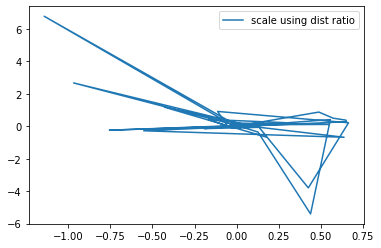

In [13]:
x0 = []
y0 = []

for i in range(38):
    y0.append(translations[i][2])
    x0.append(-1*translations[i][0])

fig,axes = plt.subplots()

axes.plot(x0, y0,label = 'scale using dist ratio')
#axes.plot(gx, gz,color = 'red',label = 'ground_truth')
axes.legend()

plt.show()